# Introduction

## Background

5th Semester of Bachelor studies (team project): Learning application for German Sign Language (DGS)

- Small and simple subset of sign language: alphabet
- Application prompts user to spell word
- User shows signs to webcam
- Application judges correctness of signs
- New signs are introduced based on users proficiency

Judging of sign correctness: **Deep Neural Network**

Available training data (at the time):

- Small image datasets
- Don't generalize to real world application

<img src="./assets/sign-language-mnist.png" width="800"/>

**-> Creation of own dataset**

## Dataset

**German Sign Language (DGS) Alphabet**

"A dataset containing hand landmark vectors of all static DGS alphabet signs"

In [1]:
import kaggle

# Download dataset from Kaggle

# Copy the `kaggle.json` credentials into required directory
# Reference: https://www.kaggle.com/docs/api
! cp kaggle.json ~/.kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('moritzkronberger/german-sign-language', path='./dataset', unzip=True)

In [1]:
import pandas as pd

# Load dataset into pandas DataFrame
df = pd.read_csv('./dataset/german_sign_language.csv')
df.head()

,label,coordinate 0,coordinate 1,coordinate 2,coordinate 3,coordinate 4,coordinate 5,coordinate 6,coordinate 7,coordinate 8,...,coordinate 53,coordinate 54,coordinate 55,coordinate 56,coordinate 57,coordinate 58,coordinate 59,coordinate 60,coordinate 61,coordinate 62
0,a,0.699433,0.694308,-5.125001e-07,0.648201,0.623592,-0.013627,0.620721,0.537524,-0.020144,...,-0.021148,0.727923,0.482140,-0.033280,0.721847,0.531752,-0.020166,0.734710,0.541902,-0.006052
1,a,0.287428,0.724731,-7.136206e-07,0.333253,0.645310,-0.004472,0.353996,0.556867,-0.004307,...,-0.014462,0.234728,0.502905,-0.026811,0.247920,0.550634,-0.014552,0.246706,0.571273,-0.000709
2,a,0.617013,0.686834,-6.380658e-07,0.570582,0.624196,-0.011878,0.552030,0.537164,-0.014551,...,-0.017643,0.673824,0.515292,-0.028738,0.659775,0.554122,-0.017304,0.662979,0.563075,-0.005874
3,a,0.300630,0.673777,-6.232622e-07,0.348136,0.606056,-0.007175,0.372517,0.517414,-0.005305,...,-0.009060,0.254527,0.433360,-0.020325,0.264090,0.484955,-0.005042,0.259576,0.507539,0.011589
4,a,0.310373,0.682686,-6.560297e-07,0.355722,0.603330,-0.007532,0.374108,0.519388,-0.008015,...,-0.010770,0.263386,0.461493,-0.023728,0.273920,0.509182,-0.012250,0.264512,0.525097,0.000815


The letters "j" and "z" are missing from the dataset:

- German Sign Language: "j" and "z" require motion
- Difficult to recognize from still image (or pose)
- Omitted for simplicity

In [2]:
# List unique labels
labels = df['label'].unique()
labels

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'],
      dtype=object)

### Dataset Statistics

- Total of 7306 samples
- Mean of 304.417 samples per label
- Min: 258 (letter "p")
- Max: 344 (letter "l")

In [3]:
# Dataset statistics

num_samples = len(df)
num_samples

samples_per_label = df.label.value_counts().sort_index()

mean = samples_per_label.mean()
max_num_l = samples_per_label.max()
min_num_l = samples_per_label.min()
max_l = samples_per_label.idxmax()
min_l = samples_per_label.idxmin()

print(
    f"Total number of samples: {num_samples}\n"
    f"Mean samples per label: {mean}\n"
    f"Min samples per label: {min_num_l} ({min_l})\n"
    f"Max samples per label: {max_num_l} ({max_l})\n"
)

Total number of samples: 7306
Mean samples per label: 304.4166666666667
Min samples per label: 258 (p)
Max samples per label: 344 (l)



Labels are fairly equally distributed.

<Axes: xlabel='label'>

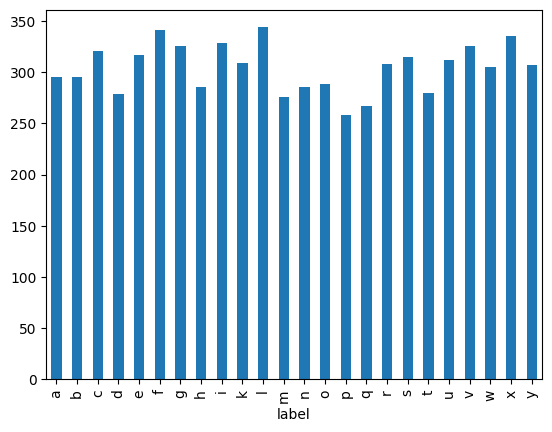

In [5]:
df['label'].value_counts().sort_index().plot(kind='bar')

### Dataset Contents

"Handpose Landmarks":

<img src="./assets/mediapipe-hand-landmarks.png" width="800"/>

- 3D coordinates of hand joints
- Generated using MediaPipe Handpose
- Normalized between [0, 1]

This is the German Sign Language alphabet:

<img src="./assets/german-sign-language-alphabet.png" width="800"/>

Let's have a look at some signs/ handposes:

In [57]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def np_coords_to_landmarks(hand_coords):
    """Convert numpy array containing a hand's landmark coordinates as a numpy array of shape `(21, 3)`
    into list of MediaPipe `NormalizedLandmarks`.
    """
    hand_landmarks = [
        landmark_pb2.NormalizedLandmark(x=coord[0], y=coord[1], z=coord[2])
        for coord
        in hand_coords
    ]
    return hand_landmarks


def draw_landmarks(hand_landmarks, height=460, width=460):
    """Draw hand landmarks into empty image.
    
    Adapted from:
    https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=_JVO3rvPD4RN&line=11&uniqifier=1
    """
    # Create empty image
    image = np.full((height, width, 3), 255, dtype=np.uint8)

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) 
        for landmark
        in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
        image,
        hand_landmarks_proto,
        solutions.hands.HAND_CONNECTIONS,
        solutions.drawing_styles.get_default_hand_landmarks_style(),
        solutions.drawing_styles.get_default_hand_connections_style()
    )

    return image

In [84]:
from typing import Literal
import matplotlib.pyplot as plt

def visualize_hand_landmarks(df, idx, mode: Literal["2d", "3d"] = "2d"):
    # Load linearized coordinates into numpy array
    linearized_coordinates = df.loc[:, df.columns!="label"].to_numpy()

    # Reshape linear coordinates into 3D coordinates
    hand_landmark_coords = linearized_coordinates.reshape((linearized_coordinates.shape[0], -1, 3))

    # Load labels
    labels = df['label']

    # Find global indices of the idx-th labels in data frame
    unique_labels = df['label'].unique()
    viz_indices = []
    for label in unique_labels:
        label_indices = df.index[df['label'] == label].tolist()
        viz_indices.append(label_indices[idx])

    # Determine how many rows and columns will be needed
    num_rows = int(np.sqrt(len(viz_indices)))
    num_columns = int(np.ceil(len(viz_indices) / num_rows))
    aspect_ratio= num_rows / num_columns

    # Create plot
    width = 25
    height = int(width * aspect_ratio)
    fig = plt.figure(figsize=(width, height))

    # Add subplots
    for i in range(len(viz_indices)):
        ax = fig.add_subplot(
            num_rows,
            num_columns,
            i+1,
            projection="3d" if mode == "3d" else None
        )
        df_idx = viz_indices[i]
        label = labels[df_idx]
        hand_coords = hand_landmark_coords[df_idx]
        if mode == "2d":
            # Convert to MediaPipe landmarks
            hand_landmarks = np_coords_to_landmarks(hand_coords)
            # Draw landmarks as image
            img = draw_landmarks(hand_landmarks)
            ax.imshow(img)
            ax.axis('off')
        else:
            for vec in hand_coords:
                ax.scatter(vec[0], vec[2], vec[1], color='b')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            #ax.set_zlabel('Z')

        ax.set_title(f"Sign: {label.upper()}")

    plt.suptitle(f"Visualisierung: {mode}")
    plt.show()
    plt.close()

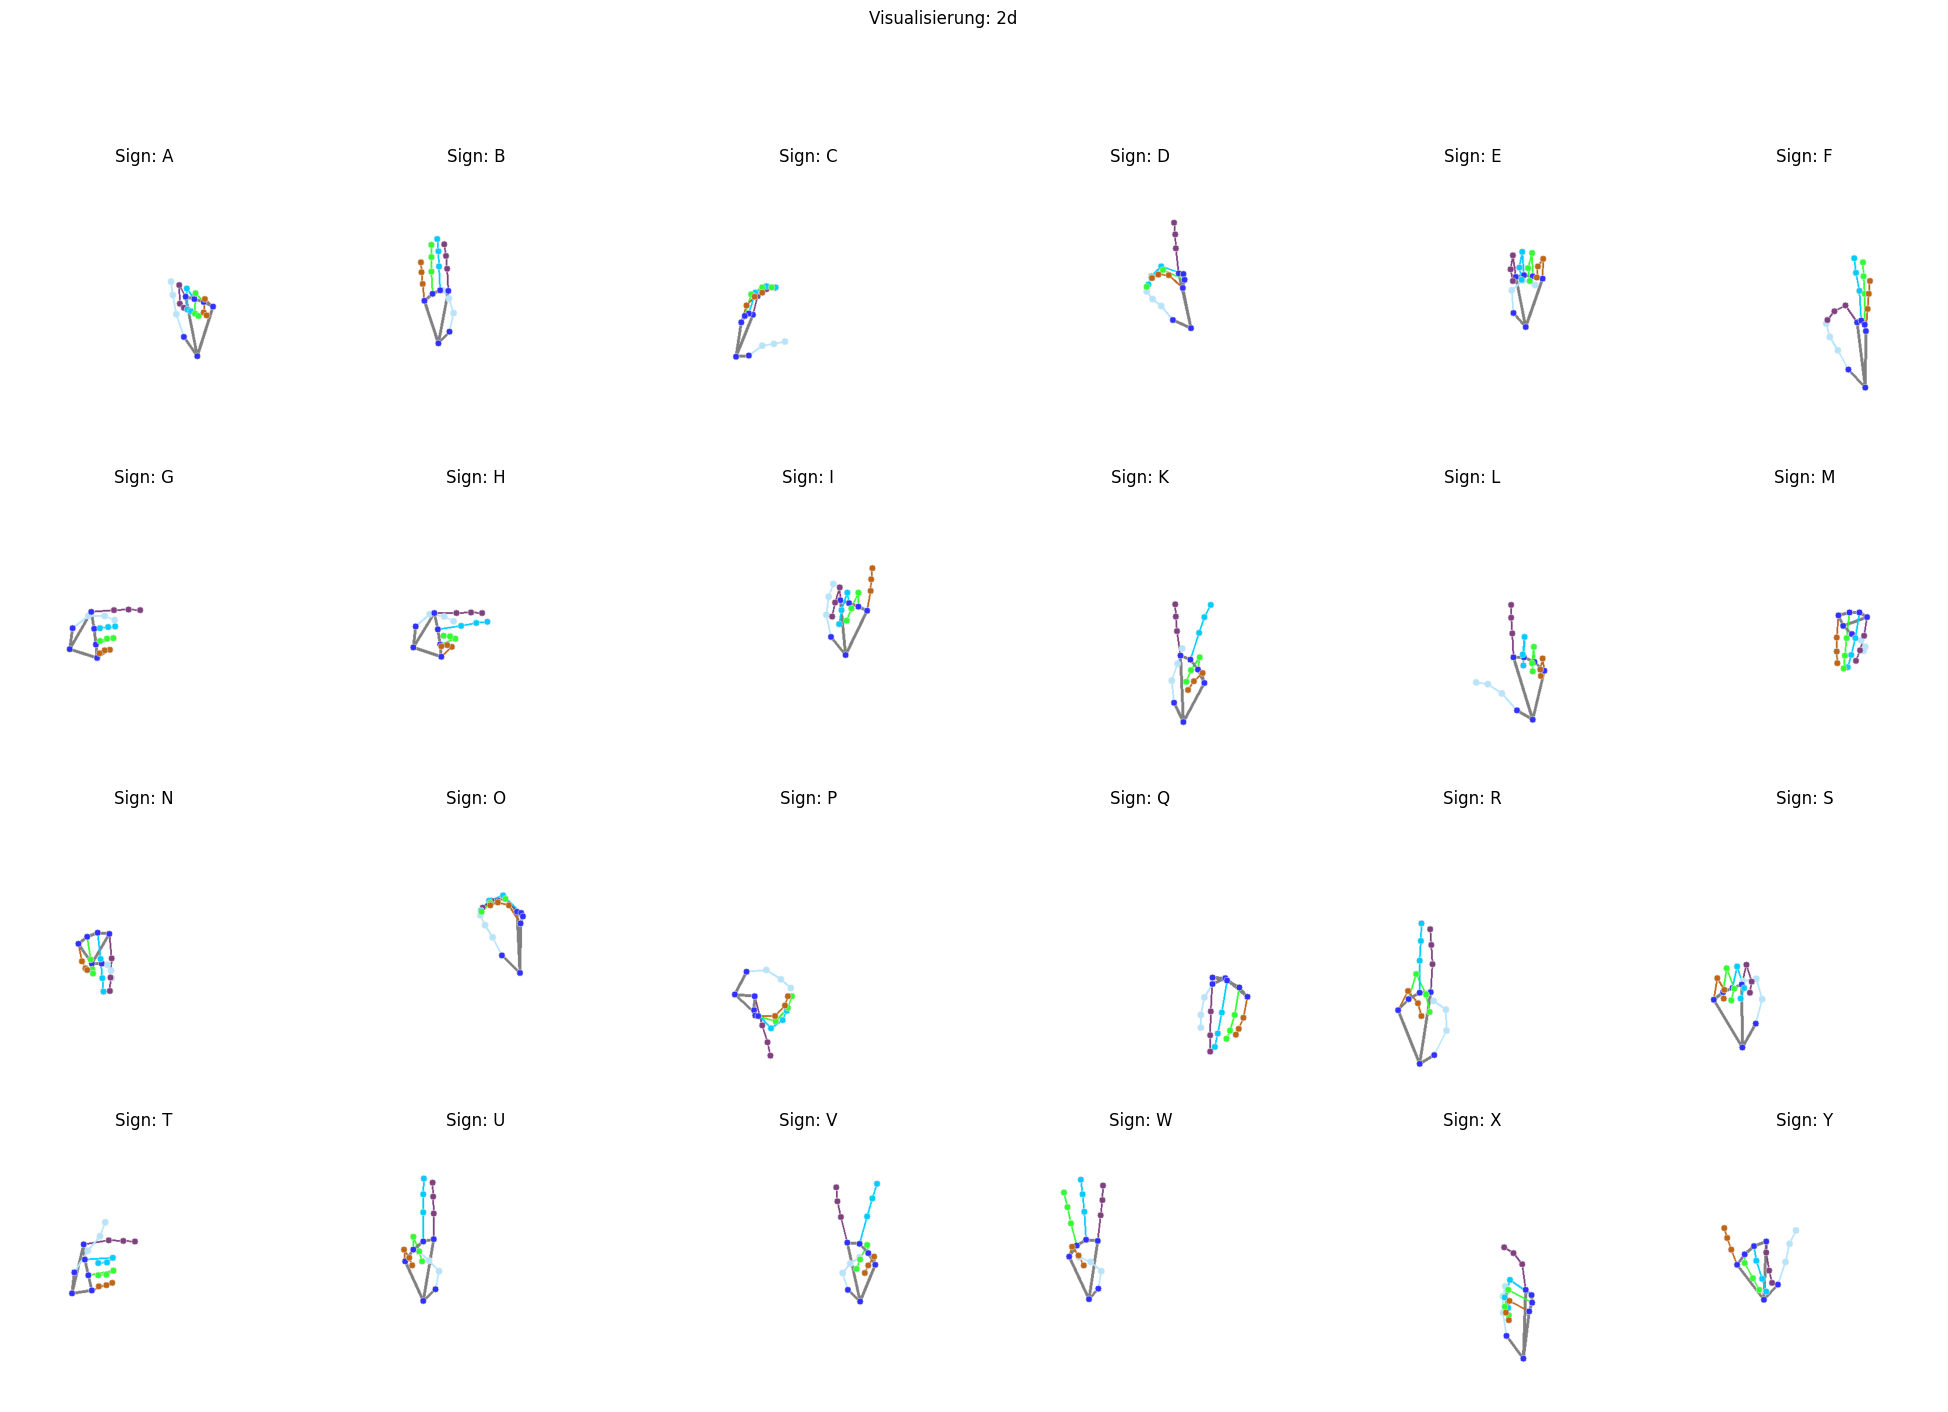

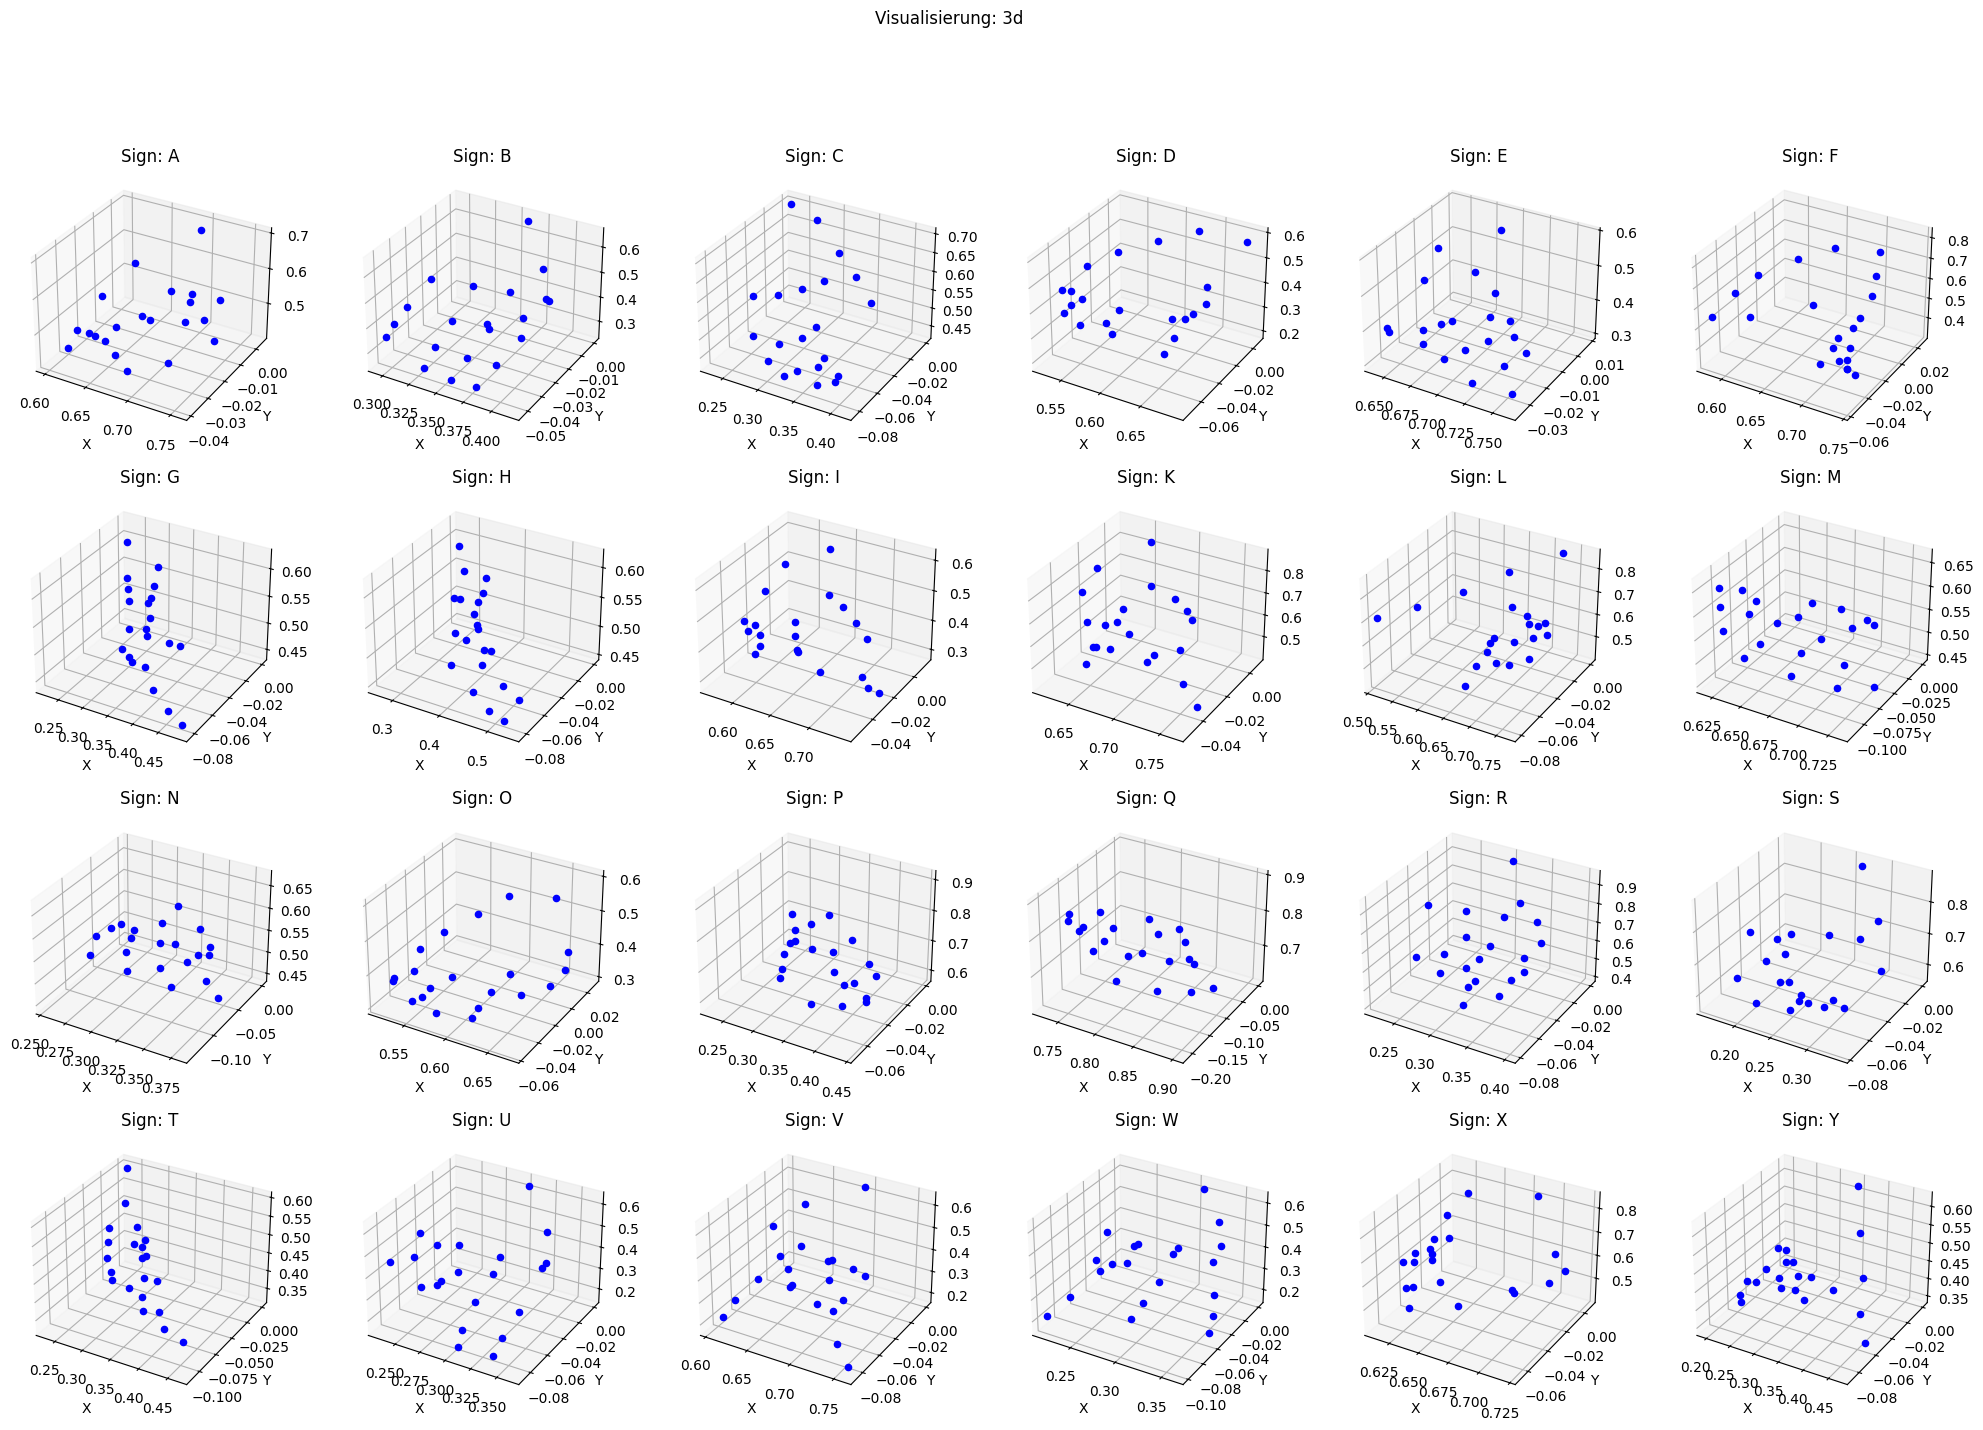

In [85]:
# Visualize alphabet signs as 2D images
visualize_hand_landmarks(df, 0)

# Visualize signs as 3D points
visualize_hand_landmarks(df, 0, mode="3d")

## The Problem

Task of sign recognition neural network: handpose classification

Want to add new signs to learning application?

- Collect samples of new sign (~300)
- Re-train entire neural network

Disadvantages:

- Labour intensive
- Unreliable (model performance might change with every re-training)

Idea:
- No need for full classifier
- Objective: Does user's sign match required sign (well enough)?
- Similarity predictor that works for any handpose?

**-> One-Shot Handpose Recognition**

## Research Questions

Q1: What Deep Learning methods can be used for One-Shot Handpose Recognition?

Q2: Which method performs best on the _German Sign Language (DGS) Alphabet_ dataset?

Q3: Can Few-Shot Recognition improve upon One-Shot Performance?